In [1]:
import networkx as nx
import rumor_centrality.rumor_detection as raw
import rumor_centrality.jordan_center_alternative as jo
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from rumor_centrality.graph_generator import scale_free, small_world
from time import time
from multiprocessing import Pool

In [2]:
samples = 5
sizes = [10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 1000]

In [3]:
def get_gnp_01(n):
        return nx.fast_gnp_random_graph(n, 0.1)
def get_gnp_03(n):
    return nx.fast_gnp_random_graph(n, 0.3)
def get_gnp_06(n):
    return nx.fast_gnp_random_graph(n, 0.6)

In [4]:
def get_rand_tree(n):
    return nx.random_tree(n)

In [5]:
def get_complete_graph(n):
    return nx.complete_graph(n)

In [6]:
def get_timing(args):
    g = args[0](args[1])
    start = time()
    raw.get_center_prediction(raw.networkx_graph_to_adj_list(g), use_fact=False)
    return len(g.edges), time() - start

In [7]:
def gather_results(graph_generating_callback):
    results = []
    with Pool(samples) as p:
        for n in tqdm(sizes):
            data = p.map(get_timing, [(graph_generating_callback, n) for _ in range(samples)])
            avg_edges = [d[0] for d in data]
            avg_edges = sum(avg_edges) / len(avg_edges)

            avg_timings = [d[1] for d in data]
            avg_timings = sum(avg_timings) / len(avg_timings)

            r = {
                "n": n,
                "m": avg_edges,
                "avg time": avg_timings,
                "degree": avg_edges / n,
            }
            results.append(r)
    return results

In [8]:
experiments = {
    "GNP 0.1": get_gnp_01,
    "GNP 0.3": get_gnp_03,
    "GNP 0.6": get_gnp_06,
    "Rand Tree": get_rand_tree,
    "Compl. Graph": get_complete_graph,
}

results = {}
for key, callback in experiments.items():
    results[key] = gather_results(callback)

100%|██████████████████████████████████████████████████████████████████████| 11/11 [01:16<00:00,  6.97s/it]


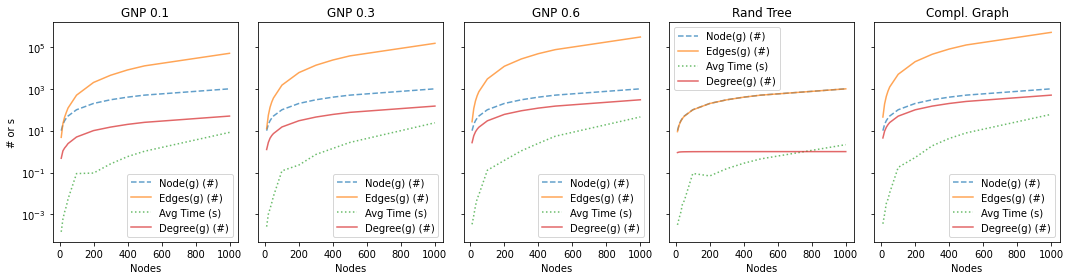

In [13]:
fig, axes = plt.subplots(1, len(experiments), figsize=(15, 4), sharey=True)

for i, key in enumerate(experiments.keys()):
    axes[i].plot(sizes, [r["n"] for r in results[key]], "--", label="Node(g) (#)", alpha=0.7)
    axes[i].plot(sizes, [r["m"] for r in results[key]], label="Edges(g) (#)", alpha=0.7)
    axes[i].plot(sizes, [r["avg time"] for r in results[key]], ":", label="Avg Time (s)", alpha=0.7)
    axes[i].plot(sizes, [r["degree"] for r in results[key]], label="Degree(g) (#)", alpha=0.7)
    axes[i].legend()
    axes[i].set_title(key)
    axes[i].set_yscale("log")
    axes[i].set_xlabel("Nodes")
    
axes[0].set_ylabel("# or s")
fig.tight_layout()